
# <center><h2>Facial Keypoints Detection with ResNet</h2></center>
This notebook demonstrates how to build and train a deep convolutional neural network (ResNet) for facial keypoint detection using PyTorch. We will:

1. Load and preprocess the training and test datasets.
2. Define custom Dataset classes and DataLoaders.
3. Implement a Residual block and assemble a ResNet model.
4. Set up loss, optimizer, and learning rate scheduler.
5. Write training, validation, and prediction loops (with early stopping).
6. Visualize training progress and sample predictions.
7. Generate a submission file for Kaggle.

---

## 1. Import Libraries and Load the Datasets

We start by importing the necessary Python packages and reading the CSV files into pandas DataFrames.  
We will refer to:
- `training.csv`: images and keypoint labels for training.  
- `test.csv`: images without labels for final submission.  
- `IdLookupTable.csv`: mapping to format the submission.

---

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

path = os.path.abspath(os.getcwd())
training_data = pd.read_csv(os.path.join(path, 'training.csv'))
test_data = pd.read_csv(os.path.join(path, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(path, 'SampleSubmission.csv'))
id_lookup_table = pd.read_csv(os.path.join(path, 'IdLookupTable.csv'))

print(f"Training samples: {len(training_data)}, Test samples: {len(test_data)}")

Training samples: 7049, Test samples: 1783


## 2. Data Preprocessing

- Convert the space‑separated pixel strings into normalized 96×96 arrays.  
- Extract keypoint coordinates and normalize / handle missing values.

---

In [2]:
# Extract Image and Keypoints data
images = np.array([
    np.fromstring(img_str, sep=' ', dtype=np.float32).reshape(96, 96)
    for img_str in training_data['Image']
]) / 255.0

# Extract Image data from test dataset
test_images = np.array([
    np.fromstring(img_str, sep=' ', dtype=np.float32).reshape(96, 96)
    for img_str in test_data['Image']
]) / 255.0

# Extract keypoints (float32), keep NaNs for missing annotations
keypoints = training_data.drop(columns=['Image']).to_numpy(dtype=np.float32)

# Shuffle and Split train/validation sets (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    images, keypoints, test_size=0.2, random_state=42
)

print(f"Train/Val split: {X_train.shape[0]} / {X_val.shape[0]}")

Train/Val split: 5639 / 1410


## 3. Define Dataset Classes and DataLoaders

We create two custom Dataset classes:
1. `FacialKeypointsDataset` for labeled data (train/val).
2. `FacialKeypointsTestDataset` for test data.

Then wrap them in DataLoader objects for batching.

---

In [3]:
class FacialKeypointsDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        img = torch.tensor(self.X[idx][None, ...], dtype=torch.float32)
        keypts = torch.tensor(self.y[idx], dtype=torch.float32)
        return img, keypts

class FacialKeypointsTestDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        img = torch.tensor(self.X[idx][None, ...], dtype=torch.float32)
        return img
    
# Create DataLoaders
dataloader_train = DataLoader(
    FacialKeypointsDataset(X_train, y_train), batch_size=16, shuffle=True
)
dataloader_val = DataLoader(
    FacialKeypointsDataset(X_val, y_val), batch_size=16, shuffle=False
)
dataloader_test = DataLoader(
    FacialKeypointsTestDataset(test_images), batch_size=16, shuffle=False
)

# Preview a batch
imgs, kps = next(iter(dataloader_train))
print(imgs.shape, kps.shape)

torch.Size([16, 1, 96, 96]) torch.Size([16, 30])


## 4. Build a ResNet Model

We implement a basic Residual block and stack multiple blocks to form a small ResNet suited for 96×96 grayscale images.  
The final fully‑connected layer outputs 30 values (x,y for 15 keypoints).

---

In [4]:
class Residual(nn.Module):
    def __init__(self, in_ch, out_ch, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.conv3 = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=strides) if use_1x1conv else None
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)


def resnet_block(in_ch, out_ch, num_residuals, first_block=False):
    layers = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            layers.append(Residual(in_ch, out_ch, use_1x1conv=True, strides=2))
        else:
            layers.append(Residual(out_ch, out_ch))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(1,32,3,1,1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(3,2,1)
        )
        self.b2 = resnet_block(32,32,2, first_block=True)
        self.b3 = resnet_block(32,64,2)
        self.b4 = resnet_block(64,128,2)
        self.b5 = resnet_block(128,256,2)
        self.b6 = resnet_block(256,512,2)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, 30)
    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.pool(X).view(-1,512)
        return self.fc(X)

# Instantiate and move to GPU if available
model = ResNet().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print(model)

ResNet(
  (b1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    (0): Residual(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(32, eps=1e-05

## 5. Loss Function, Optimizer, and Scheduler

We define a custom MSE loss that ignores NaNs in the target, then use Adam optimizer with a StepLR scheduler.

---

In [5]:
class MSELossIgnoreNan(nn.Module):
    def forward(self, pred, label):
        mask = torch.isfinite(label)
        loss = (pred[mask] - label[mask])**2
        return loss.mean()

criterion = MSELossIgnoreNan()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## 6. Training and Validation Routines

Define reusable functions for one epoch of training and validation.

---

In [6]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
    return total_loss / len(loader.dataset)


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = criterion(preds, y)
            total_loss += loss.item() * X.size(0)
    return total_loss / len(loader.dataset)

## 7. Training Loop with Early Stopping

Train for up to 100 epochs, saving the best model by validation loss and stopping if no improvement for 5 epochs.

---

In [ ]:
best_val = float('inf')
patience = 5
counter = 0
train_hist, val_hist = [], []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

for epoch in range(1, 101):
    train_loss = train_one_epoch(model, dataloader_train, criterion, optimizer, device)
    val_loss = validate(model, dataloader_val, criterion, device)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    scheduler.step()
    print(f"Epoch {epoch}: train={train_loss:.4f}, val={val_loss:.4f}")
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break


Using device: cuda
Epoch 1: train=405.7132, val=13.7431
Epoch 2: train=11.4242, val=9.2995
Epoch 3: train=8.6611, val=8.4423
Epoch 4: train=6.9531, val=7.6556
Epoch 5: train=5.8939, val=6.7138
Epoch 6: train=4.4545, val=5.4809
Epoch 7: train=4.0053, val=5.6778
Epoch 8: train=3.9122, val=5.4958
Epoch 9: train=3.6131, val=5.5625
Epoch 10: train=3.4892, val=5.5456
Epoch 11: train=3.2447, val=5.4240
Epoch 12: train=3.2085, val=5.4205
Epoch 13: train=3.2573, val=5.4511
Epoch 14: train=3.1825, val=5.4618
Epoch 15: train=3.2017, val=5.4196
Epoch 16: train=3.0571, val=5.4241
Epoch 17: train=3.0858, val=5.4258
Epoch 18: train=3.0347, val=5.3579
Epoch 19: train=3.0933, val=5.3956
Epoch 20: train=3.0663, val=5.3753
Epoch 21: train=3.1203, val=5.4089
Epoch 22: train=3.0775, val=5.4412
Epoch 23: train=3.1033, val=5.3948
Early stopping


## 8. Plot Training Curve

Visualize the training and validation loss over epochs.

---

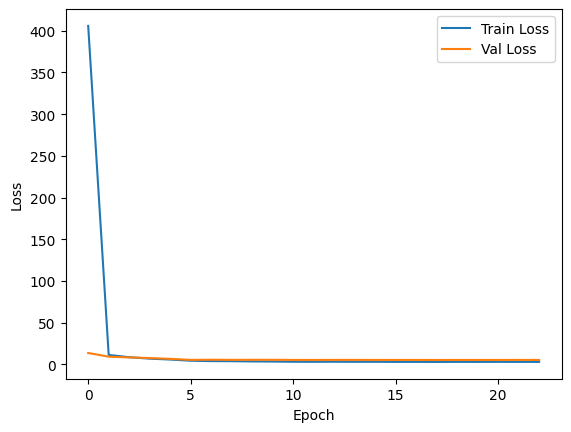

In [8]:
plt.plot(train_hist, label='Train Loss')
plt.plot(val_hist, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 9. Load Best Model and Make Predictions

Restore the best model and generate predictions on the test set.

---

In [9]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds = []
with torch.no_grad():
    for X in dataloader_test:
        X = X.to(device)
        preds = model(X).cpu().numpy()
        all_preds.append(preds)
predictions = np.vstack(all_preds)
predictions = np.clip(predictions, 0, 96)


C:\Users\kingk\AppData\Local\Temp\ipykernel_15744\2886608309.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


## 10. Visualize Sample Predictions

Plot a few random images from the training set with predicted keypoints overlaid.

---

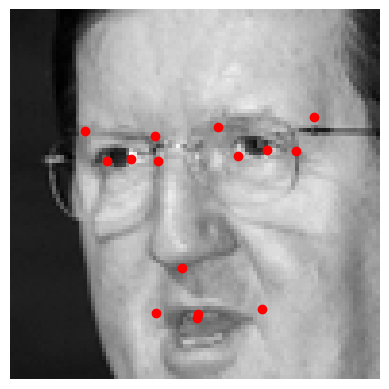

In [10]:
def show_keypoints(img, kps):
    plt.imshow(img, cmap='gray')
    plt.scatter(kps[0::2], kps[1::2], c='r')
    plt.axis('off')

# Show one batch from training
Xb, yb = next(iter(dataloader_train))
yb_pred = model(Xb.to(device)).detach().cpu().numpy()
idx = np.random.randint(len(Xb))
show_keypoints(Xb[idx][0].numpy(), yb_pred[idx])

## 11. Prepare Submission File

Use the `IdLookupTable.csv` to map each predicted keypoint to the required submission format and write out `submission.csv`.

---

In [11]:
submission_rows = []
features = training_data.columns[:-1]
for _, row in id_lookup_table.iterrows():
    img_idx = int(row['ImageId']) - 1
    feat = row['FeatureName']
    feat_idx = list(features).index(feat)
    val = predictions[img_idx, feat_idx]
    submission_rows.append({
        'RowId': row['RowId'],
        'Location': val
    })
submission = pd.DataFrame(submission_rows)
submission.to_csv('submission.csv', index=False)

print("Saved submission.csv")

Saved submission.csv
